# Satvision-TOA Reconstruction Comaprison Plotting Notebook

# Pt 1/2

Version: 06.06.24

Env: `Python [conda env:ilab-pytorch]`
Env (discover): `Python [conda env:ilab]`

In [1]:
!pip install yacs timm segmentation-models-pytorch termcolor webdataset==0.2.86

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import sys
import time
import joblib
import random
import datetime
from tqdm import tqdm
import numpy as np
import logging

import torch
import torch.cuda.amp as amp

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import warnings

warnings.filterwarnings('ignore') 

In [3]:
sys.path.append('../../pytorch-caney')

from pytorch_caney.config import get_config

from pytorch_caney.models.build import build_model

from pytorch_caney.ptc_logging import create_logger

from pytorch_caney.data.datasets.mim_modis_22m_dataset import MODIS22MDataset

from pytorch_caney.data.transforms import SimmimTransform, SimmimMaskGenerator

from pytorch_caney.config import _C, _update_config_from_file

## 1. Configuration

### Clone model ckpt from huggingface

```bash
# On prism/explore
module load git-lfs

git lfs install

git clone git clone git@hf.co:nasa-cisto-data-science-group/satvision-toa-huge-patch8-window12-192
```

Note: If using git w/ ssh, make sure you have ssh keys enabled to clone using ssh auth.
https://huggingface.co/docs/hub/security-git-ssh

```bash
eval $(ssh-agent)

# If this outputs as anon, follow the next steps.
ssh -T git@hf.co

# Check if ssh-agent is using the proper key
ssh-add -l

# If not
ssh-add ~/.ssh/your-key

# Or if you want to use the default id_* key, just do
ssh-add

```

### if performing reconstruction tests on discover, softlink the model weights and associated yaml config file

In [4]:
# MODEL_PATH: str = '../../mim_pretrain_swinv2_h_satvision_128_window8_patch8_3e4_100ep/ckpt_epoch_99/mp_rank_00_model_states.pt'
# CONFIG_PATH: str = '../../mim_pretrain_swinv2_satvision_huge_128_window8_patch8_100ep.yaml'
# MODEL_PATH: str = '../../mim_satvision_pretrain-huge/mim_pretrain_swinv2_h_satvision_128_window8_mpatch8_scaled_100ep/ckpt_epoch_88/mp_rank_00_model_states.pt'
# CONFIG_PATH: str = '../../mim_pretrain_swinv2_satvision_huge_128_window8_mpatch8_onecycle_100ep.yaml'
# MODEL_PATH: str = '../../satvision-toa-huge-patch8-window12-192/mp_rank_00_model_states.pt'
# CONFIG_PATH: str = '../../satvision-toa-huge-patch8-window12-192/mim_pretrain_swinv2_satvision_huge_192_window12_100ep.yaml'
# MODEL_PATH: str = '../../3b_26m_8p/mp_rank_00_model_states.pt'
# CONFIG_PATH: str = '../../3b_26m_8p/mim_pretrain_swinv2_satvision_giant_192_window12_200ep.yaml'
# MODEL_PATH: str = '../../3b.2m.discover.nodecay.6nodes/mp_rank_00_model_states.pt'
# CONFIG_PATH: str = '../../3b.2m.discover.nodecay.6nodes/mim_pretrain_swinv2_satvision_giant_128_window08_100ep.yaml'
MODEL_PATH: str = '../../mim_satvision_pretrain-huge/mim_pretrain_swinv2_h_satvision_128_window8_mpatch8_scaled_rsb_scaled_100ep/ckpt_epoch_99/mp_rank_00_model_states.pt'
CONFIG_PATH: str = '../../mim_pretrain_swinv2_satvision_huge_128_window8_patch8_onecycle_100ep.yaml'


OUTPUT: str = '.'
TAG: str = 'satvision-huge-toa-reconstruction'
DATA_PATH: str = '/discover/nobackup/cssprad1/calebtest/3dclouds.runs/development/validation_test/data/sv_toa_128_chip_validation_04_24.npy'
DATA_PATHS: list = [DATA_PATH]

In [5]:
# Update config given configurations

config = _C.clone()
_update_config_from_file(config, CONFIG_PATH)

config.defrost()
config.MODEL.RESUME = MODEL_PATH
config.DATA.DATA_PATHS = DATA_PATHS
config.OUTPUT = OUTPUT
config.TAG = TAG
config.freeze()

=> merge config from ../../mim_pretrain_swinv2_satvision_huge_128_window8_patch8_onecycle_100ep.yaml


In [6]:
# Configure logging
logging.basicConfig(
    filename='app.log',  # Specify the log file name
    level=logging.INFO,  # Set logging level to DEBUG
    format='%(asctime)s [%(levelname)s] %(message)s',  # Specify log message format
    datefmt='%Y-%m-%d %H:%M:%S'  # Specify date format
)

# Add logging to standard output
console = logging.StreamHandler()  # Create a handler for standard output
console.setLevel(logging.INFO)  # Set logging level for standard output
console.setFormatter(logging.Formatter('%(asctime)s [%(levelname)s] %(message)s'))  # Set log message format for standard output
logger = logging.getLogger('')
logger.addHandler(console)

## 2. Load model weights from checkpoint

In [7]:
checkpoint = torch.load(MODEL_PATH)
model = build_model(config, pretrain=True)
model.load_state_dict(checkpoint['module']) # If 'module' not working, try 'model'
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info(f"number of params: {n_parameters}")
# model.cuda() # For some reason cuda not working on JH discover ilab kernel. I think due to not sles15
model.eval()

2024-06-10 10:17:27,888 [INFO] number of params: 695328632


MiMModel(
  (encoder): SwinTransformerV2ForSimMIM(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(14, 352, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=352, input_resolution=(32, 32), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=352, input_resolution=(32, 32),num_heads=4, window_size=8, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=352, window_size=(8, 8), pretrained_window_size=(0, 0), num_heads=4
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=4, bias=False)
              )
              (qkv): Linea

In [16]:
import torchvision.transforms as T
from pytorch_caney.data.utils import RandomResizedCropNP, SimmimMaskGenerator

class MinMaxEmissiveScaleReflectance(object):
    """
    Performs scaling of MODIS TOA data
    - Scales reflectance percentages to reflectance units (% -> (0,1))
    - Performs per-channel minmax scaling for emissive bands (k -> (0,1))
    """

    def __init__(self):
        
        self.reflectance_indices = [0, 1, 2, 3, 4, 6]
        self.emissive_indices = [5, 7, 8, 9, 10, 11, 12, 13]

        self.emissive_mins = np.array(
            [223.1222, 178.9174, 204.3739, 204.7677,
             194.8686, 202.1759, 201.3823, 203.3537],
            dtype=np.float32)

        self.emissive_maxs = np.array(
            [352.7182, 261.2920, 282.5529, 319.0373,
             295.0209, 324.0677, 321.5254, 285.9848],
            dtype=np.float32)

    def __call__(self, img):
        
        # Reflectance % to reflectance units
        img[:, :, self.reflectance_indices] = \
            img[:, :, self.reflectance_indices] * 0.01
        
        # Brightness temp scaled to (0,1) range
        img[:, :, self.emissive_indices] = \
            (img[:, :, self.emissive_indices] - self.emissive_mins) / \
                (self.emissive_maxs - self.emissive_mins)
        
        return img


class SimmimTransform:
    """
    torchvision transform which transforms the input imagery into
    addition to generating a MiM mask
    """

    def __init__(self, config):

        self.transform_img = \
            T.Compose([
                MinMaxEmissiveScaleReflectance(), # New transform for MinMax
                RandomResizedCropNP(scale=(0.67, 1.),
                                    ratio=(3. / 4., 4. / 3.)),
                T.ToTensor(),
                #lambda x: x / 500.0,
                #T.ConvertImageDtype(dtype=torch.float32),
                #torchvision.ops.Permute(dims=[1, 2, 0]),
                T.Resize((config.DATA.IMG_SIZE, config.DATA.IMG_SIZE)),
            ])

        if config.MODEL.TYPE in ['swin', 'swinv2']:

            model_patch_size = config.MODEL.SWINV2.PATCH_SIZE

        else:

            raise NotImplementedError

        self.mask_generator = SimmimMaskGenerator(
            input_size=config.DATA.IMG_SIZE,
            mask_patch_size=config.DATA.MASK_PATCH_SIZE,
            model_patch_size=model_patch_size,
            mask_ratio=config.DATA.MASK_RATIO,
        )

    def __call__(self, img):

        img = self.transform_img(img)
        mask = self.mask_generator()

        return img, mask

## 3. Load evaluation set (from numpy file)

In [17]:
# Use the Masked-Image-Modeling transform
transform = SimmimTransform(config)

# The reconstruction evaluation set is a single numpy file
validation_dataset_path = DATA_PATH
validation_dataset = np.load(validation_dataset_path)
len_batch = range(validation_dataset.shape[0])

# Apply transform to each image in the batch
# A mask is auto-generated in the transform
imgMasks = [transform(validation_dataset[idx]) for idx \
    in len_batch]

# Seperate img and masks, cast masks to torch tensor
img = torch.stack([imgMask[0] for imgMask in imgMasks])

mask = torch.load('mask_192.pt')

if config.DATA.IMG_SIZE == 128:
    mask = mask[:, 8:-8, 8:-8]

In [18]:
idx_to_band = {
    0: 1,
    1: 2,
    2: 3,
    3: 6,
    4: 7,
    5: 21,
    6: 26,
    7: 27,
    8: 28,
    9: 29,
    10: 30,
    11: 31,
    12: 32,
    13: 33
}


def get_batch_info(img):
    
    channels = img.shape[1]
    
    for channelIdx in range(channels):
        channel = idx_to_band[channelIdx]
        img_band_array = img[:, channelIdx, :, :]
        min_ = img_band_array.min()
        mean_ = img_band_array.mean()
        max_ = img_band_array.max()
        print(f'Channel {channel}, min {min_}, mean {mean_}, max {max_}') 

In [19]:
get_batch_info(img)

Channel 1, min 0.00787659827619791, mean 0.2306605875492096, max 0.9887060523033142
Channel 2, min -0.00038768138620071113, mean 0.2931264340877533, max 0.9125235676765442
Channel 3, min 0.039573196321725845, mean 0.2628457546234131, max 1.032042145729065
Channel 6, min -0.026754550635814667, mean 0.22612576186656952, max 0.6638308763504028
Channel 7, min -0.02489299885928631, mean 0.15096446871757507, max 0.6149790287017822
Channel 21, min 0.013017232529819012, mean 0.5206390619277954, max 0.9244224429130554
Channel 26, min -0.021210160106420517, mean 0.030266068875789642, max 0.5291910171508789
Channel 27, min 0.03513594716787338, mean 0.7143411636352539, max 0.999663233757019
Channel 28, min 0.015452031046152115, mean 0.583636462688446, max 0.993326723575592
Channel 29, min 0.023415686562657356, mean 0.6118876338005066, max 1.0035899877548218
Channel 30, min 0.004206456709653139, mean 0.6180419921875, max 1.0000258684158325
Channel 31, min 0.012684257701039314, mean 0.60364729166030

## 4. Prediction helper functions

In [12]:
def minmax_norm(img_arr, minmax=None):
    if minmax:
        arr_min, arr_max = minmax
    else:
        arr_min = img_arr.min()
        arr_max = img_arr.max()
    img_arr_scaled = (img_arr - arr_min) / (arr_max - arr_min)
    img_arr_scaled = img_arr_scaled * 255
    img_arr_scaled = img_arr_scaled.astype(np.uint8)
    return img_arr_scaled


def process_mask(mask, repeat=3, axis=-1):
    mask_img = mask.unsqueeze(0)
    mask_img = mask_img.repeat_interleave(4, 1).repeat_interleave(4, 2).unsqueeze(1).contiguous()
    mask_img = mask_img[0, 0, :, :]
    mask_img = mask_img[:, :, None].repeat_interleave(repeat, -1).numpy()
    if not axis == -1:
        mask_img = np.moveaxis(mask_img, -1, axis) 
    return mask_img


def process_prediction(image, img_recon, mask, rgb_index, minmax, rgb=False, norm=False):

    mask_14c = process_mask(mask, repeat=14, axis=0)
    image = image.numpy()
    img_recon = img_recon.numpy()

    diff = np.where(mask_14c == 1, (img_recon - image), np.nan)
    image_recon_masked = np.where(mask_14c == 0, image, img_recon)

    if rgb:

        # ---
        # Process RGB version
        # ---
        mask_3c = process_mask(mask)
    
        red_idx = rgb_index[0]
        blue_idx = rgb_index[1]
        green_idx = rgb_index[2]


        rgb_image = np.stack((image[red_idx, :, :],
                              image[blue_idx, :, :],
                              image[green_idx, :, :]),
                              axis=-1)
        rgb_image = minmax_norm(rgb_image, None) if norm else rgb_image



    
        rgb_image_recon = np.stack((img_recon[red_idx, :, :],
                                    img_recon[blue_idx, :, :],
                                    img_recon[green_idx, :, :]),
                                    axis=-1)

        rgb_image_recon = minmax_norm(rgb_image_recon) if norm else rgb_image_recon

        diff = np.where(mask_3c == 1, (rgb_image_recon - rgb_image), np.nan) # 

        rgb_masked = np.where(mask_3c == 0, rgb_image, rgb_image_recon)
        rgb_image_masked = np.where(mask_3c == 1, rgb_image, 0)

        rgb_recon_masked = rgb_masked
        
        return rgb_image, rgb_image_masked, rgb_recon_masked, mask_3c, diff
    
    else:

        return image, image_recon_masked, diff

def save_diff_and_recons(inputs, outputs, masks, minmaxes,
                         rgb_index, size, version, rgb=False, norm=False):

    recons = []
    diffs = []

    for idx in range(len(inputs)):

        # prediction processing
        image = inputs[idx]
        img_recon = outputs[idx]
        mask = masks[idx]
        img_minmax = minmaxes[idx]



        if rgb:
            image, image_masked, img_recon_masked, mask, diff = \
                process_prediction(image, img_recon, mask, rgb_index, img_minmax, rgb=True, norm=norm)
        else:
            image, img_recon_masked, diff = process_prediction(image, img_recon, mask, rgb_index,
                                                               img_minmax, rgb=False, norm=norm)

        recons.append(img_recon_masked)
        diffs.append(diff)

    recon_filepath = f'recons{size}.v{version}.cAll.sav'
    diff_filepath = f'diffs{size}.v{version}.cAll.sav'
    joblib.dump(recons, recon_filepath)
    joblib.dump(diffs, diff_filepath)
    print(f'Saved reconstructions to {recon_filepath}')
    print(f'Saved channel diff to {diff_filepath}')


def plot_validate(inputs, outputs, masks, minmaxes, rgb_index):

    for idx in range(len(inputs)):
        # prediction processing
        image = inputs[idx]
        img_recon = outputs[idx]
        mask = masks[idx]
        minmax = minmaxes[idx]
        rgb_image, rgb_image_masked, rgb_recon_masked, mask, diff = \
            process_prediction(image, img_recon, mask, rgb_index, minmax, rgb=True, norm=True)

        # matplotlib code
        fig, (ax01, ax23) = plt.subplots(2, 2, figsize=(40, 30))
        ax0, ax1 = ax01
        ax2, ax3 = ax23
        ax2.imshow(rgb_image)
        ax2.set_title(f"Idx: {idx} MOD021KM v6.1 Bands: {rgb_index}")

        ax0.imshow(rgb_recon_masked)
        ax0.set_title(f"Idx: {idx} Model reconstruction")

        ax3.imshow(rgb_image_masked)
        ax3.set_title(f"Idx: {idx} MOD021KM Bands: {rgb_index}, masked")
        
        ax1.imshow(np.where(mask == 1, rgb_recon_masked, 0))
        ax1.set_title(f"Idx: {idx} Reconstruction Masked")


## 5. Predict

In [13]:
inputs = []
outputs = []
masks = []
losses = []
minmaxes = joblib.load('mms_128.sav')

# We could do this in a single batch however we
# want to report the loss per-image, in place of
# loss per-batch.
for i in tqdm(range(img.shape[0])):
    single_img = img[i].unsqueeze(0)
    single_mask = mask[i].unsqueeze(0)# [:, 8:-8, 8:-8]
    # single_img = single_img.cuda(non_blocking=True)
    # single_mask = single_mask.cuda(non_blocking=True)

    with torch.no_grad():
        z = model.encoder(single_img, single_mask)
        img_recon = model.decoder(z)
        loss = model(single_img, single_mask)

    inputs.extend(single_img.cpu())
    masks.extend(single_mask.cpu())
    outputs.extend(img_recon.cpu())
    losses.append(loss.cpu()) 
    
# This takes <1.5 mins for huge models, <3 mins for giant

100%|██████████| 128/128 [01:49<00:00,  1.17it/s]


## 6. Save reconstruction images and diffs

In [15]:
# Saves out 14-band reconstruction and diffs per-band.
version = 'hugeDiscover-ep88-scaledDLscaledRSB1e-2'
rgb_index = [0, 2, 1] # Indices of [Red band, Blue band, Green band]
rgb = False
norm = False
save_diff_and_recons(inputs, outputs, masks, minmaxes, rgb_index, config.DATA.IMG_SIZE, version, rgb=rgb, norm=norm)

Saved reconstructions to recons128.vhugeDiscover-ep88-scaledDLscaledRSB1e-2.cAll.sav
Saved channel diff to diffs128.vhugeDiscover-ep88-scaledDLscaledRSB1e-2.cAll.sav


## 7. Visualize reconstruction and diffs per-band.

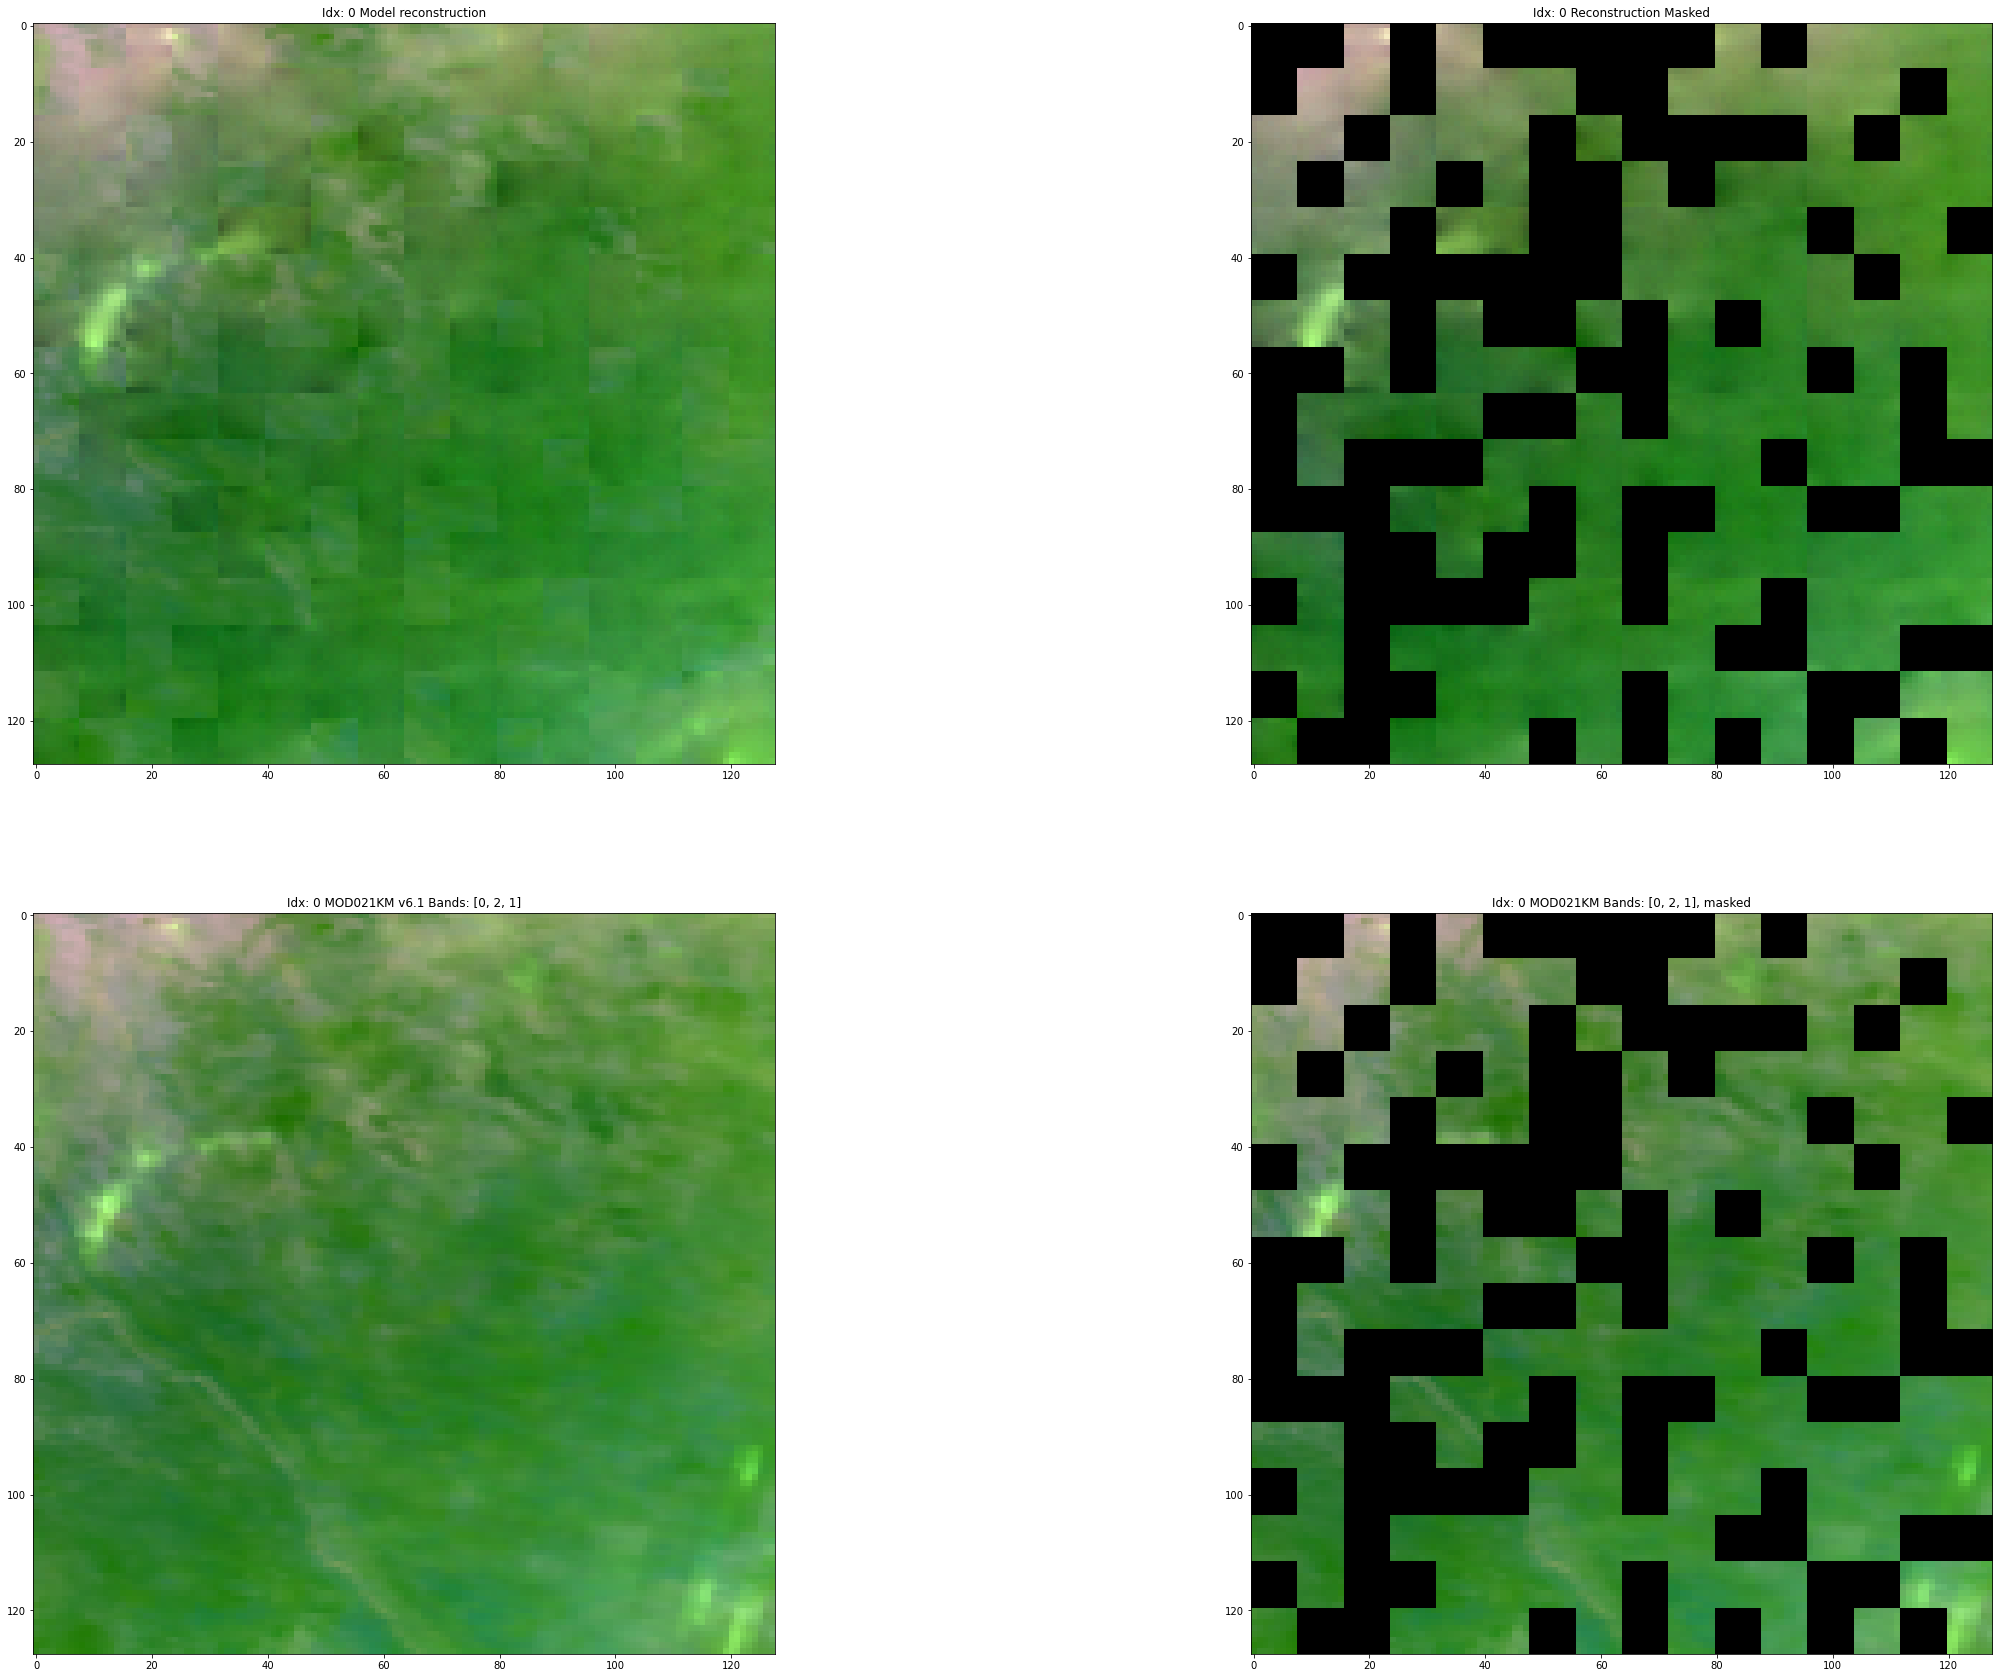

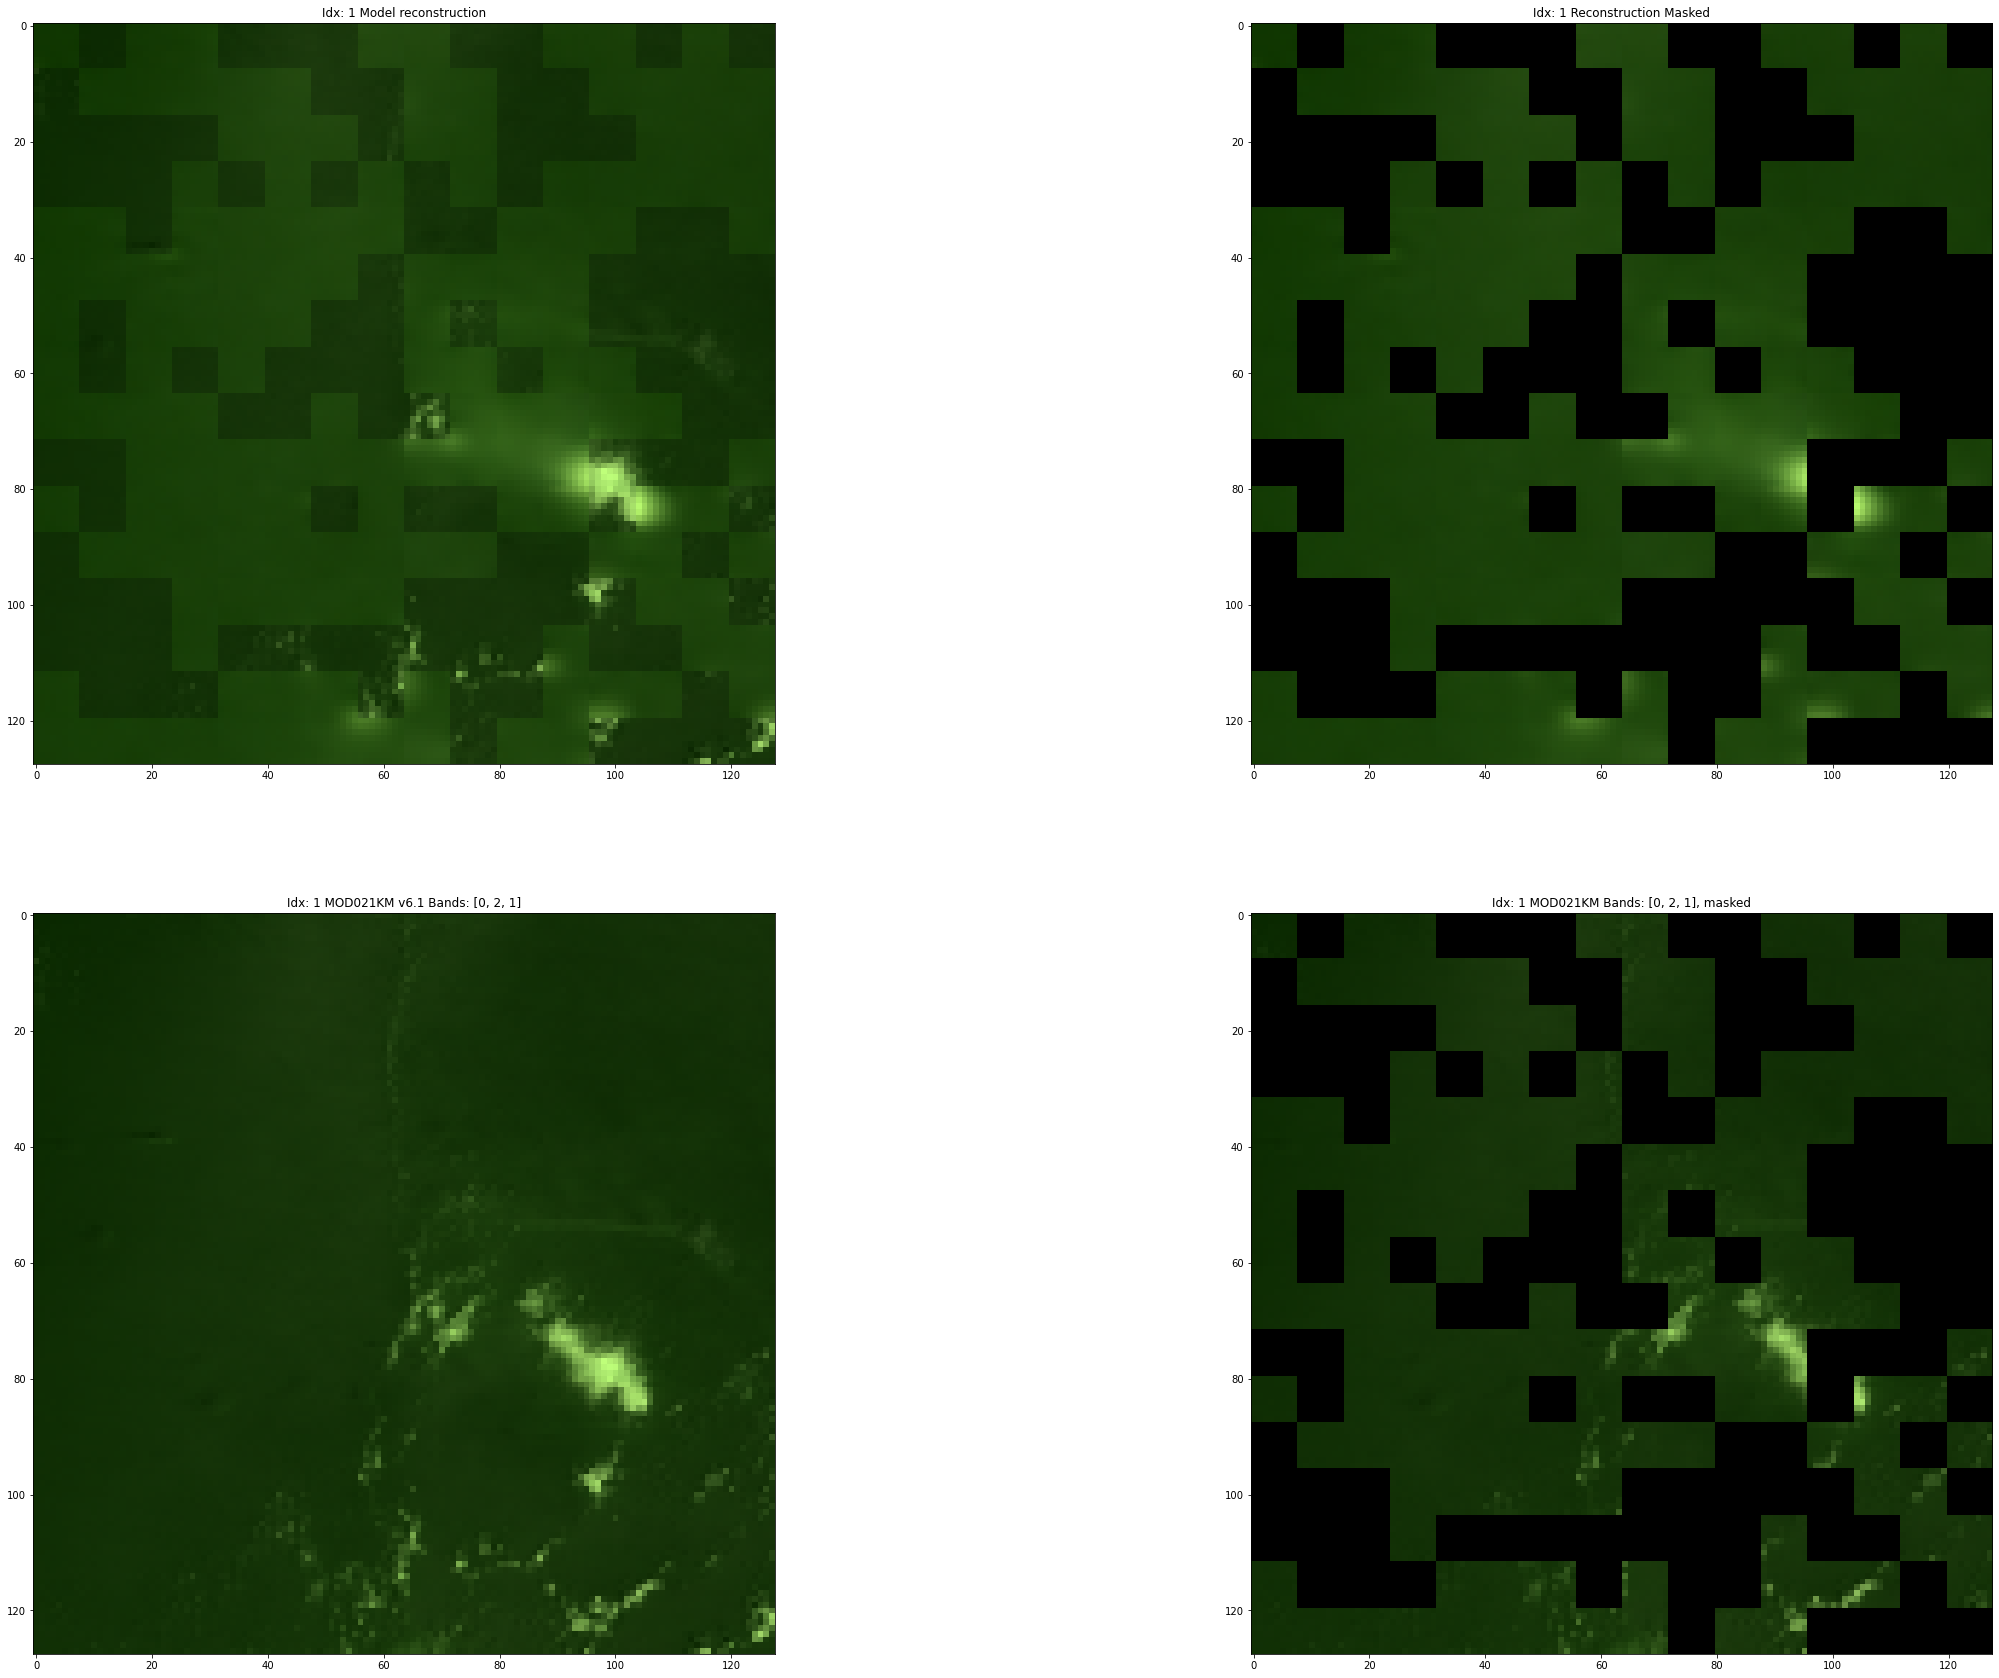

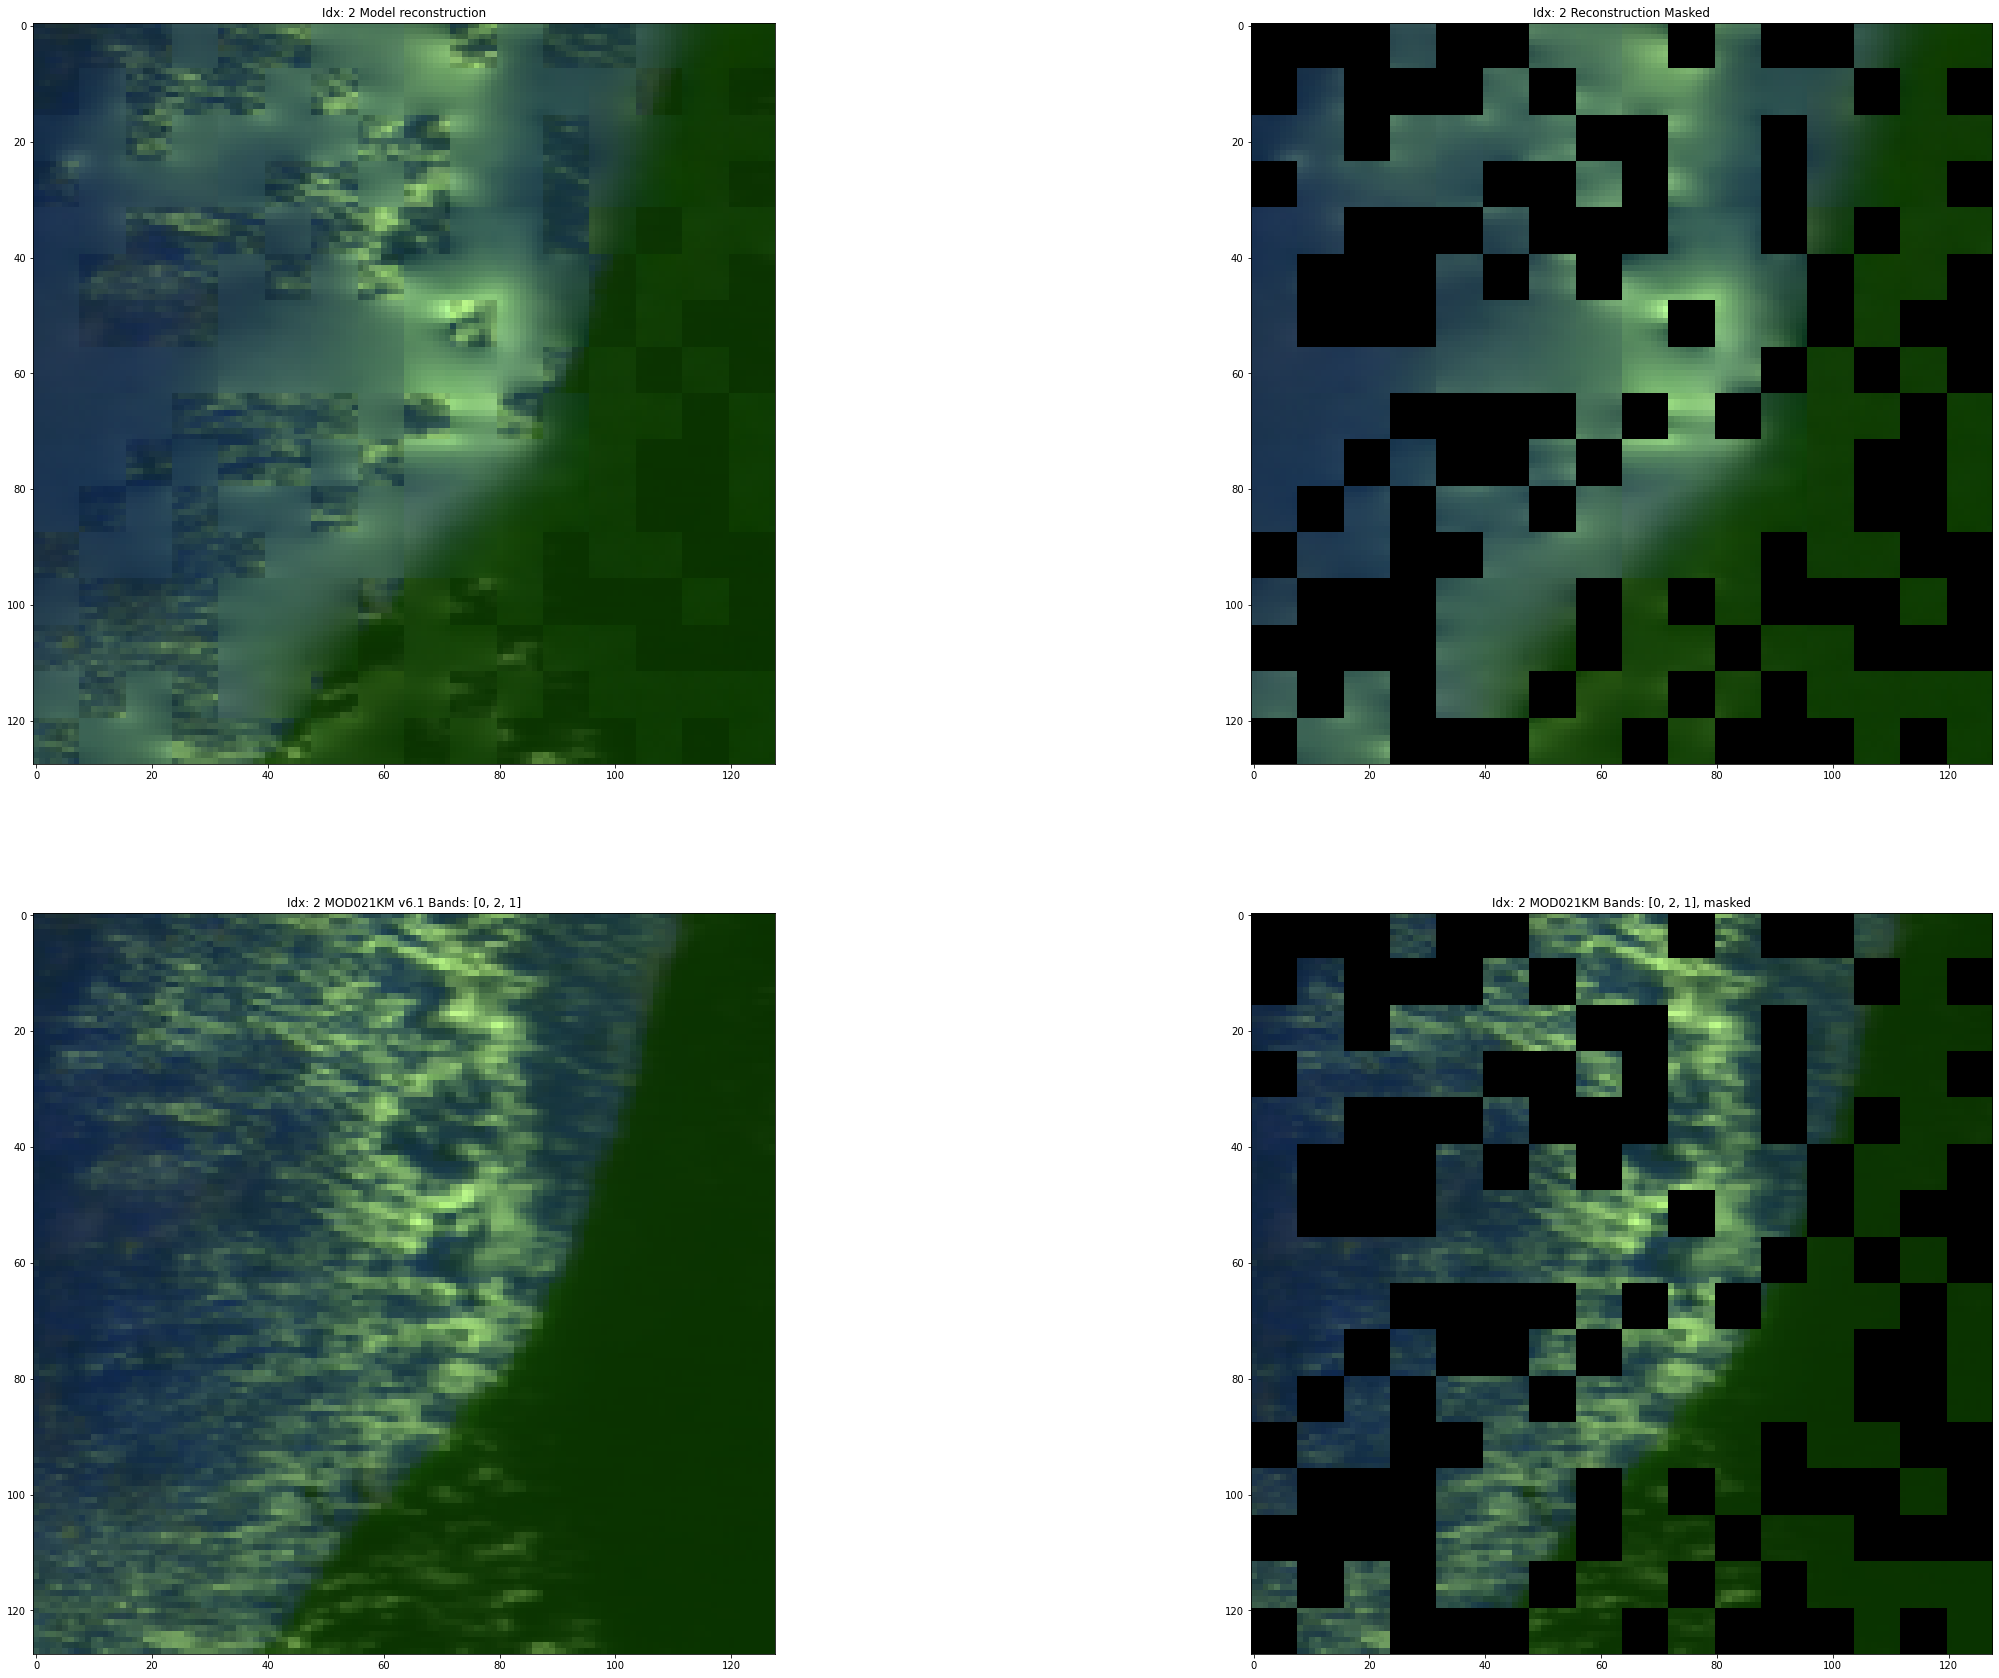

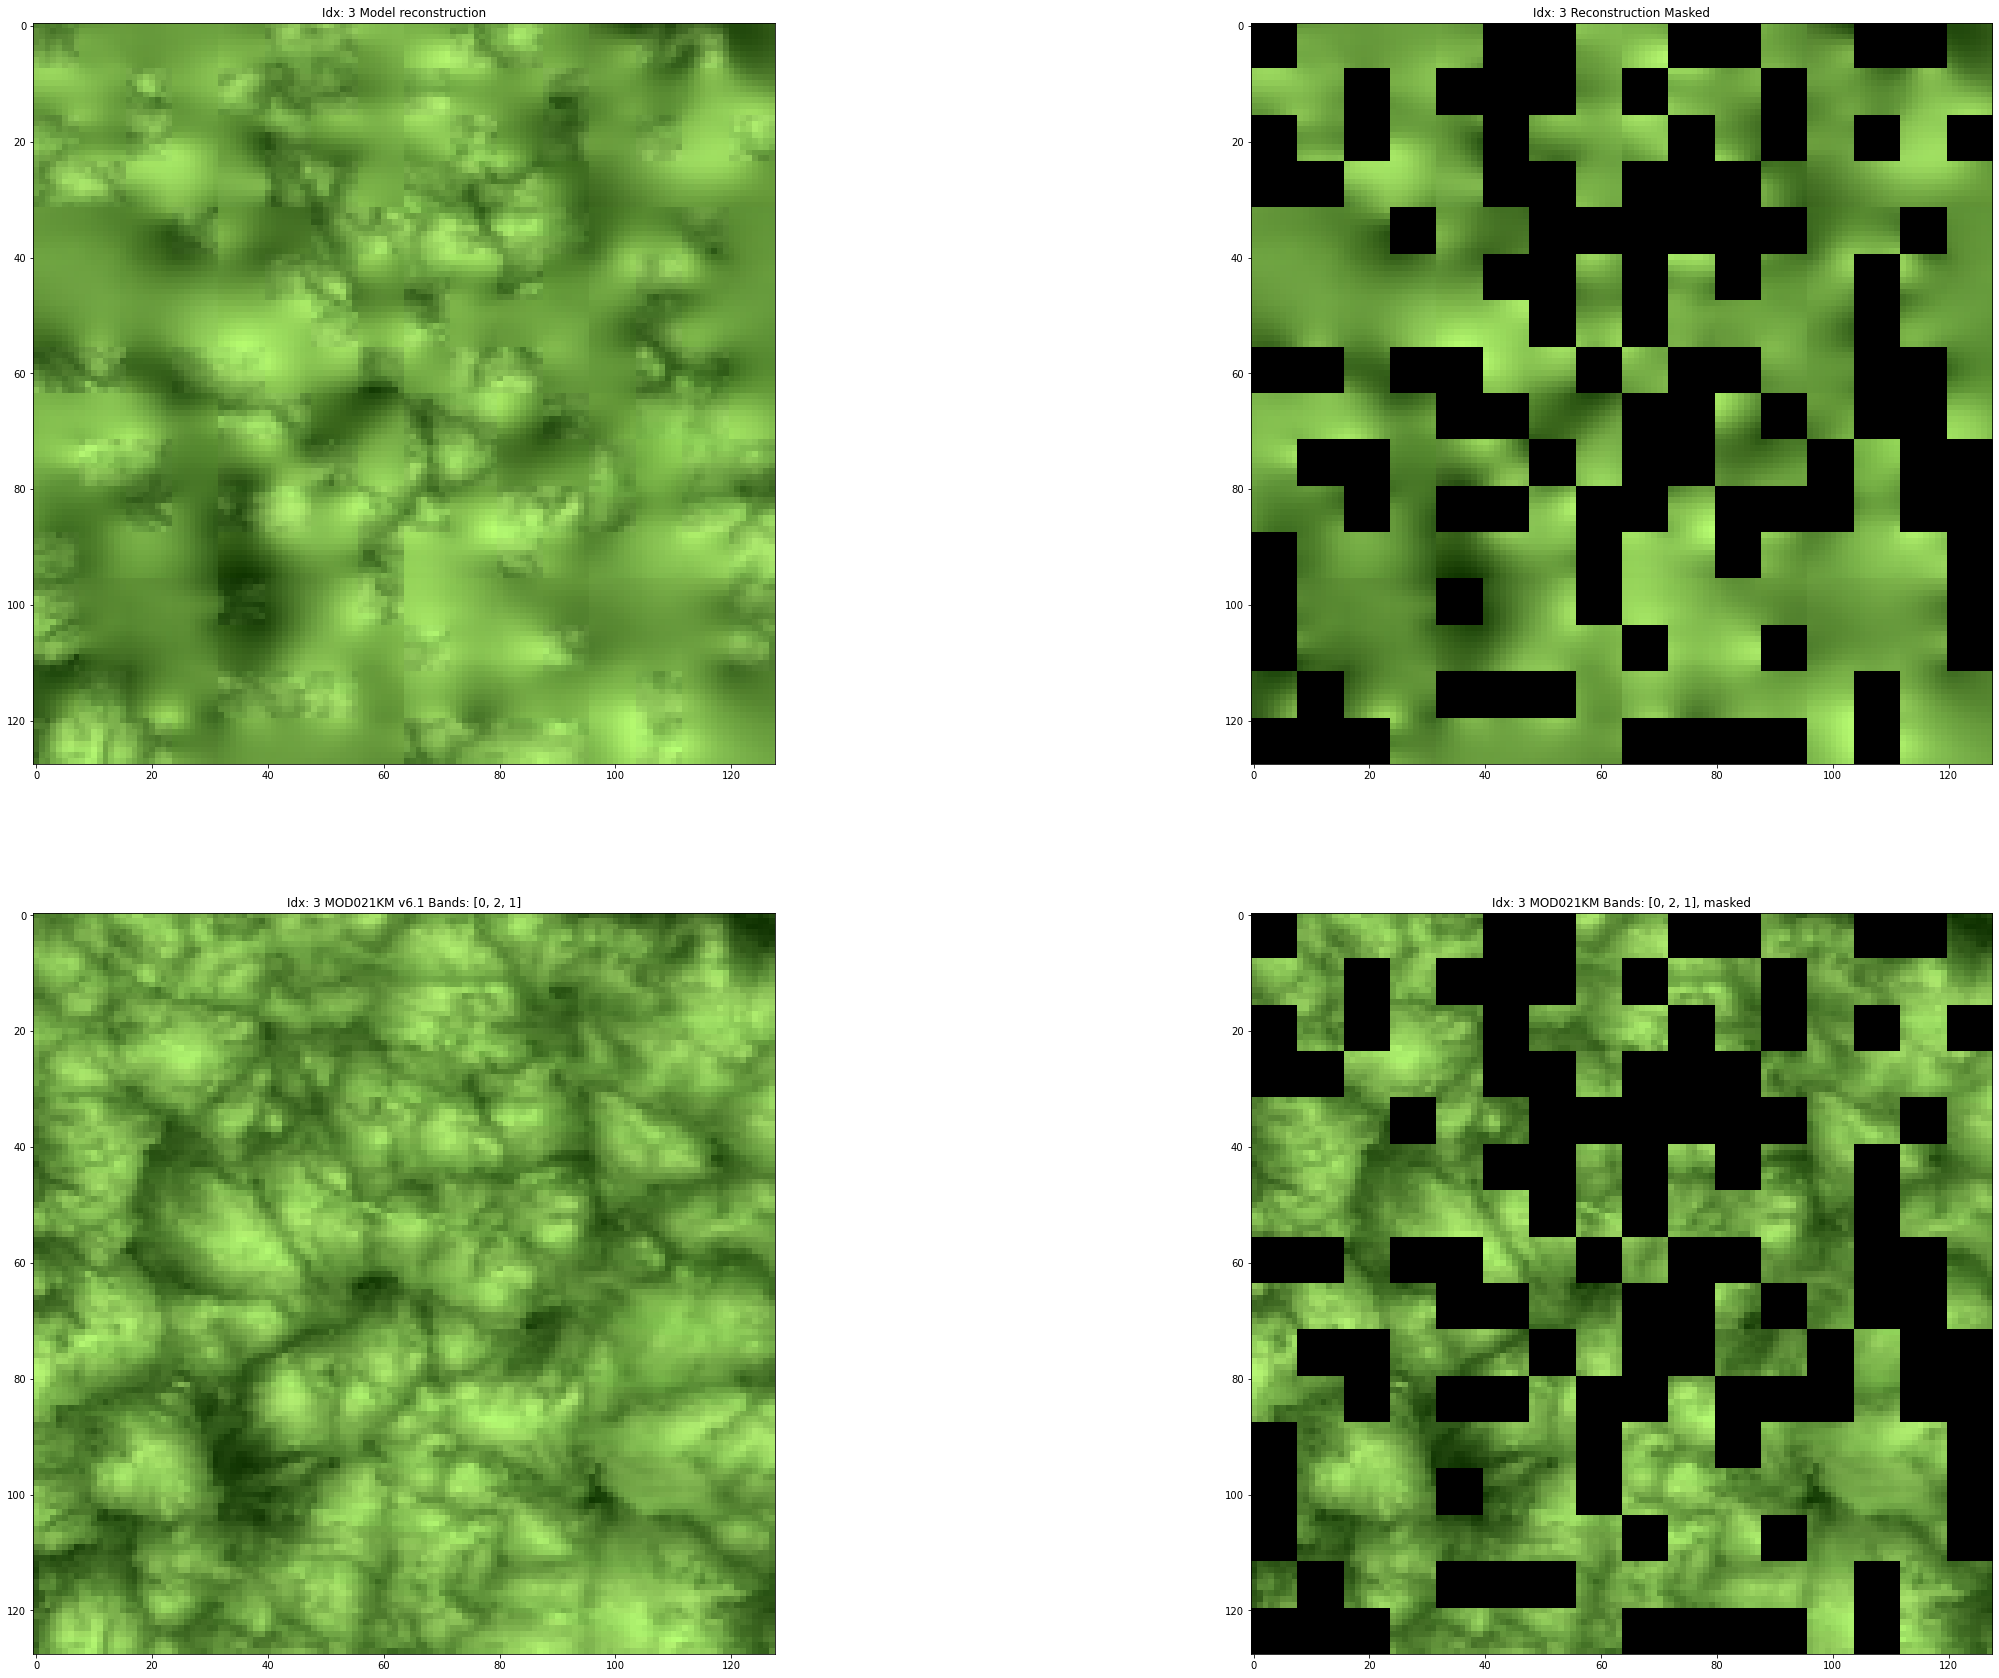

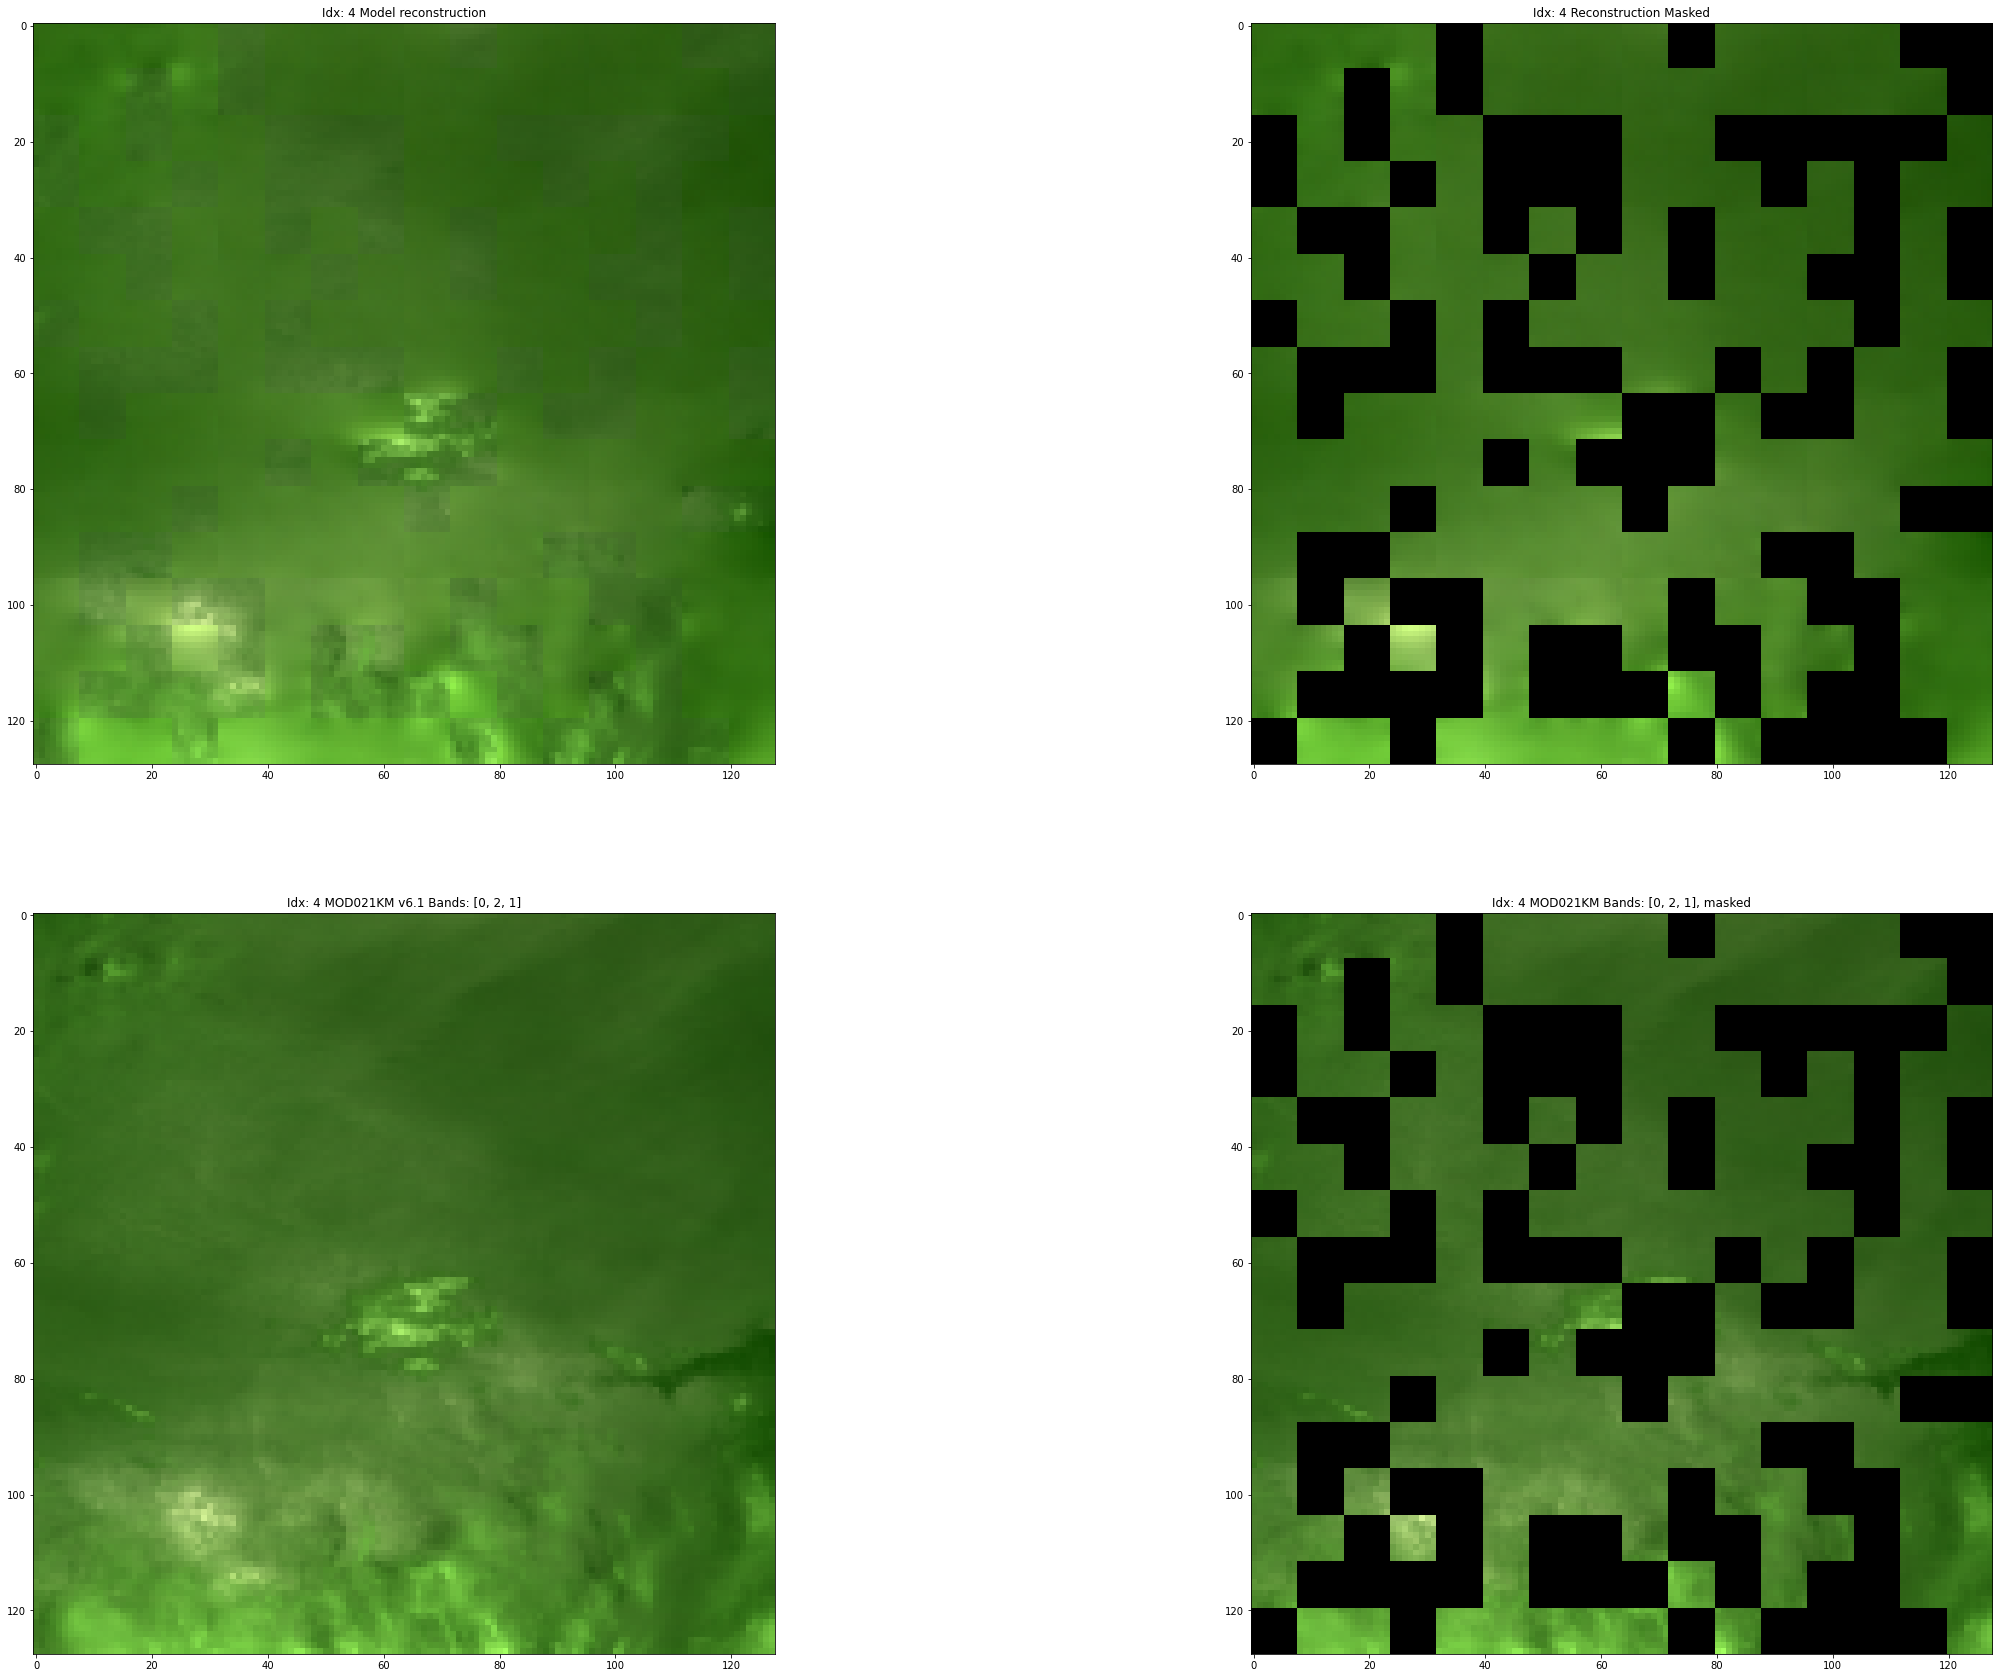

In [16]:
# Sanity check, RGB

inputs_5 = inputs[:5]
rgb_index = [0, 2, 1] # Indices of [Red band, Blue band, Green band]
# Plot RGB reconstruction, minmax normed
plot_validate(inputs_5, outputs, masks, minmaxes, rgb_index)